# 다항 회귀 (Polynomial Regression)

- 입력 데이터를 비선형 변환 후 사용하는 방법
- 모델 자체는 선형 모델

\begin{equation}
\hat{y} = w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_1^2 + w_5 x_2^2
\end{equation}

- 차수가 높아질수록 더 복잡한 데이터 학습 가능

## 구현
- 사이킷런은 다항회귀 api 를 제공x
- `PolynomialFeatures` 로 피처들을 변환한뒤, `LinearRegression` 을 순차적으로 적용해야함
- `Pipeline` 을 이용하면 두가지 api 결합을 좀더 깔끔하게 수행가능함

In [33]:
import warnings

warnings.filterwarnings( 'ignore' )

In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = X**2 + 2*X + 3 + np.random.normal(0,1, size=(m,1))
y = y.flatten() # 다차원 배열 공간을 1차원으로 평탄화
print(X.shape, y.shape)

(100, 1) (100,)


In [325]:
df = pd.DataFrame({"X":X.flatten(), "Y":y})
df.head()

,X,Y
0,0.292881,2.506392
1,1.291136,8.150132
2,0.616580,5.078994
3,0.269299,2.074877
4,-0.458071,3.781939


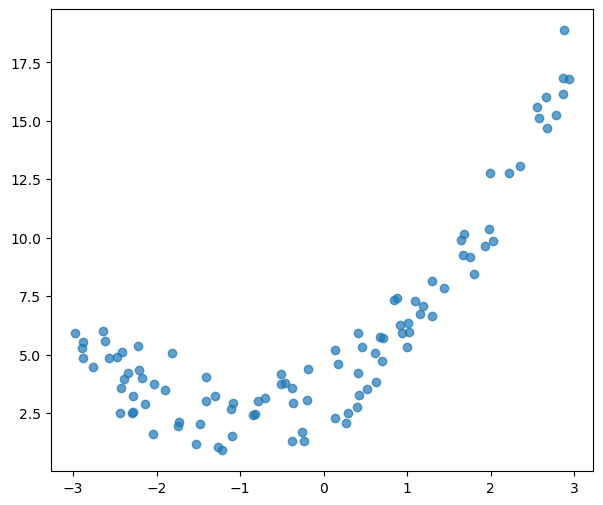

In [326]:
plt.figure(figsize=(7,6))
plt.scatter(X, y, alpha=0.7)
plt.show()

###  Linear model 생성

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [327]:
lr = LinearRegression()
lr.fit(X, y)
print(lr.coef_, lr.intercept_) # W_0 , W_1

[1.78189543] 6.175619278567208


In [202]:
pred = lr.predict(X)

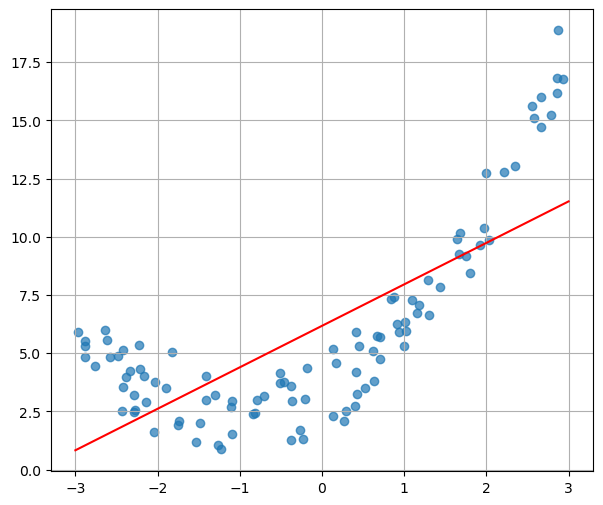

In [328]:
X_new = np.linspace(-3,3,100).reshape(-1, 1)
pred_new = lr.predict(X_new)

plt.figure(figsize=(7,6))

plt.scatter(X, y, alpha=0.7)
plt.plot(X_new, pred_new, color='red')

plt.grid(True)
plt.show()

### PolynomialFeatures를 이용해 다항회귀구현

In [329]:
from sklearn.preprocessing import PolynomialFeatures

In [330]:
poly_f = PolynomialFeatures(degree=2,  # 차원 설정
                            include_bias=False) # include_bias는 절편을 생성
X_poly = poly_f.fit_transform(X)

In [331]:
X.shape, X_poly.shape  # X_poly -> 2차식까지 존재하게 만듬

((100, 1), (100, 2))

In [96]:
poly_f.get_feature_names_out() # w_1, w_2 의 값이 결정된다.

array(['x0', 'x0^2'], dtype=object)

In [332]:
# 최고차항이 2차식이지만 linerregression을 이용해 학습한다. 대신 fit_transform을 이용해 변경된 데이터를 넣어준다.
lr2 = LinearRegression()
lr2.fit(X_poly, y)
#  3  +  2  * x +  1  * x^2  --> real
# 1 + x + x^2 poly로 만든식   --> real과 연관 있는 것 처럼 보임  (그래프상 비슷하게 나오니)
# w_0 + w_1 * x + w_2 * x^2
print(lr2.coef_, lr2.intercept_)  # w_1, w_2 (coef_ = 기울기)과 w_0(intercept_ = 절편)

[1.97906552 0.94978823] 3.3405007562628852


In [333]:
X_new = np.linspace(-3,3,100).reshape(-1, 1)
X_new_poly = poly_f.transform(X_new)
pred_new2 = lr2.predict(X_new_poly)

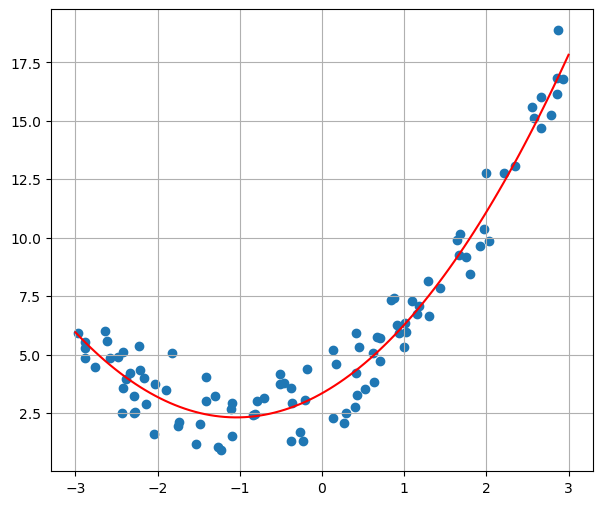

In [334]:
plt.figure(figsize=(7,6))

plt.scatter(X, y)
plt.plot(X_new, pred_new2, color='red')
plt.grid(True)
plt.show()

### 20 차원

In [335]:
pnf = PolynomialFeatures(degree=20, include_bias=False)
X_train_poly_20 = pnf.fit_transform(X)
X_train_poly_20.shape, X.shape

((100, 20), (100, 1))

In [336]:
lr = LinearRegression()
lr.fit(X_train_poly_20, y)

LinearRegression()

In [337]:
X_new = np.linspace(-3,3,100).reshape(-1, 1)
X_new_poly_20 = pnf.transform(X_new)
pred_new_20 = lr.predict(X_new_poly_20)

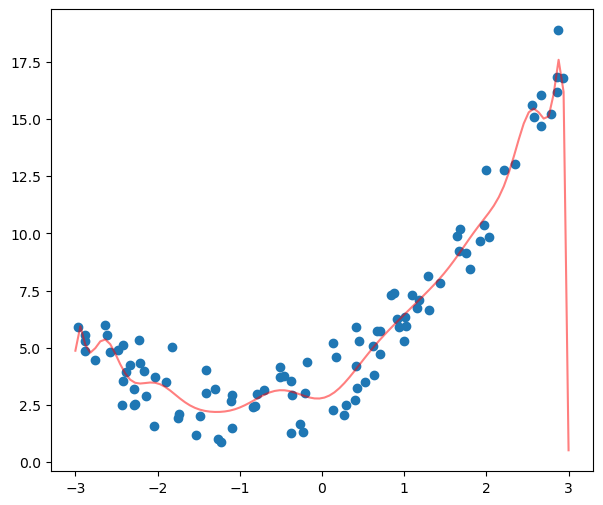

In [338]:
plt.figure(figsize=(7,6))
plt.scatter(X, y)
plt.plot(X_new, pred_new_20, color='r', alpha=0.5)
plt.show()
# 사실상 이건 overfitting이 일어났다고 봐야 됨.

In [339]:
# pipeline 생성
from sklearn.pipeline import make_pipeline

In [340]:
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [341]:
X.shape , y.shape

((100, 1), (100,))

In [342]:
model.fit(X, y) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

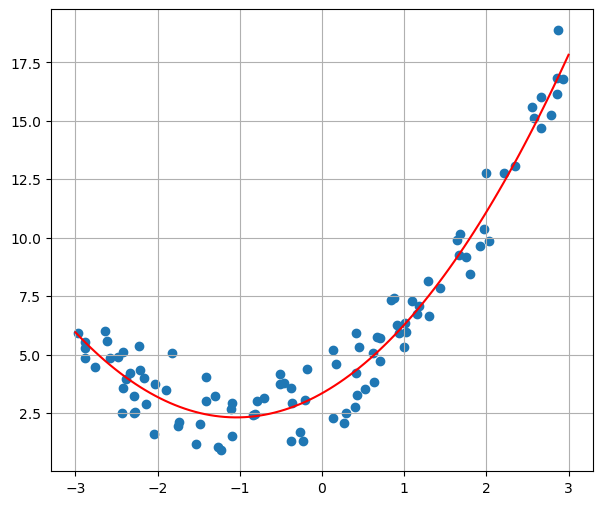

In [343]:
X_test = np.linspace(-3,3,100).reshape(-1, 1)
X_predict = model.predict(X_test)

plt.figure(figsize=(7,6))
plt.scatter(X, y)
plt.plot(X_test, X_predict, color='red')
plt.grid(True)
plt.show()

# 실습

### 보스턴 주택 가격에 대한 다항 회귀
- 2차 회귀 다항식을 이용하여 주택값을 예측해 보자.
- 예측후 R2 Score 를 확인해 보자

In [344]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_boston

In [346]:
x, y = load_boston(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [357]:
x_train[0].shape # 특징이 13개

(13,)

### PolynomialFeatures
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [368]:
pnf = PolynomialFeatures(degree=2, include_bias=True)
x_train_poly = pnf.fit_transform(x_train[0].reshape(1,13))
x_train_poly.shape # 13 -> 105

(1, 105)

In [369]:
x_train_poly

array([[1.00000000e+00, 3.96100000e-02, 0.00000000e+00, 5.19000000e+00,
        0.00000000e+00, 5.15000000e-01, 6.03700000e+00, 3.45000000e+01,
        5.98530000e+00, 5.00000000e+00, 2.24000000e+02, 2.02000000e+01,
        3.96900000e+02, 8.01000000e+00, 1.56895210e-03, 0.00000000e+00,
        2.05575900e-01, 0.00000000e+00, 2.03991500e-02, 2.39125570e-01,
        1.36654500e+00, 2.37077733e-01, 1.98050000e-01, 8.87264000e+00,
        8.00122000e-01, 1.57212090e+01, 3.17276100e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.69361000e+01,
        0.00000000e+00, 2.67285000e+00, 3.13320300e+01, 1.79055000e+02,
        3.10637070e+01, 2.59500000e+01, 1.16256000e+03, 1.04838000e+02,
        2.05991100e+03, 4.15719000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [376]:
import numpy as np
test = np.arange(2,15).reshape(1,13)
pnf = PolynomialFeatures(degree=2, include_bias=True)
test_poly = pnf.fit_transform(test)
test.shape, test_poly.shape

((1, 13), (1, 105))

In [377]:
test

array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [378]:
test_poly

array([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,
         20.,  22.,  24.,  26.,  28.,   9.,  12.,  15.,  18.,  21.,  24.,
         27.,  30.,  33.,  36.,  39.,  42.,  16.,  20.,  24.,  28.,  32.,
         36.,  40.,  44.,  48.,  52.,  56.,  25.,  30.,  35.,  40.,  45.,
         50.,  55.,  60.,  65.,  70.,  36.,  42.,  48.,  54.,  60.,  66.,
         72.,  78.,  84.,  49.,  56.,  63.,  70.,  77.,  84.,  91.,  98.,
         64.,  72.,  80.,  88.,  96., 104., 112.,  81.,  90.,  99., 108.,
        117., 126., 100., 110., 120., 130., 140., 121., 132., 143., 154.,
        144., 156., 168., 169., 182., 196.]])

## pipeline 생성

In [387]:
model = make_pipeline(
    PolynomialFeatures(degree=2),
    # StandardScaler(),  # 평균 = 0, 분산 = 1인 정규분포로 만듬
    LinearRegression()
)
model.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [388]:
print(f'Train Data Score : {model.score(x_train, y_train)}')
print(f'Test Data Score : {model.score(x_test, y_test)}')

Train Data Score : 0.9285406032650423
Test Data Score : 0.7756246164445643


In [389]:
model_1 = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    LinearRegression()
)
model_1.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [390]:
print(f'Train Data Score : {model_1.score(x_train, y_train)}')
print(f'Test Data Score : {model_1.score(x_test, y_test)}')

Train Data Score : 0.9346787783950694
Test Data Score : 0.8257864718002546


In [391]:
def plot_boston_price(expected, predicted):
  plt.figure(figsize=(8,4))
  plt.scatter(expected, predicted)
  plt.plot([5, 50], [5, 50], '--r')
  plt.xlabel('True price ($1,000s)')
  plt.ylabel('Predicted price ($1,000s)')
  plt.tight_layout()

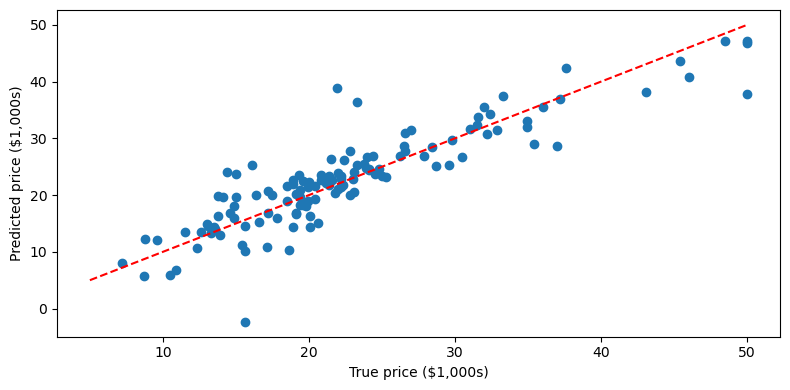

In [392]:
predicted = model.predict(x_test)
expected = y_test
plot_boston_price(expected,predicted)

In [393]:
# from sklearn.preprocessing import PolynomialFeatures
# poly_2 = PolynomialFeatures( degree=2, include_bias=False)

# X_poly_2 = poly_2.fit_transform(X)

# lr_2 = LinearRegression()
# lr_2.fit(X_poly_2, y)

# X_poly_2_predict = lr_2.predict(X_poly_2)

# from sklearn.metrics import r2_score

# r2_score(y, X_poly_2_predict)

In [318]:
# x -> 다항식 형태로 바꿈 -> x_ploy
# x_ploy를 이용해 y값을 학습시켜줌 -> 다항회귀

### 캘리포니아 주택 가격에 대한 다항 회귀

In [411]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

x_train, x_test, y_train, y_test = train_test_split(california.data, california.target, test_size=0.2)

In [412]:
model_2 = make_pipeline(
    PolynomialFeatures(degree = 2),
    # StandardScaler(),
    LinearRegression()
)
model_2.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [413]:
print(f'Train Data Score : {model_2.score(x_train, y_train)}')
print(f'Test Data Score : {model_2.score(x_test, y_test)}')

Train Data Score : 0.6836159880269567
Test Data Score : 0.6321742038173599


In [414]:
def plot_california_prices(expected, predicted):
  plt.figure(figsize = (8, 4))
  plt.scatter(expected, predicted)
  plt.plot([0, 5], [0, 5], '--r') 
  plt.xlabel('True price ($100,000s)')
  plt.ylabel('Predicted pirce ($100,000s)')
  plt.tight_layout()

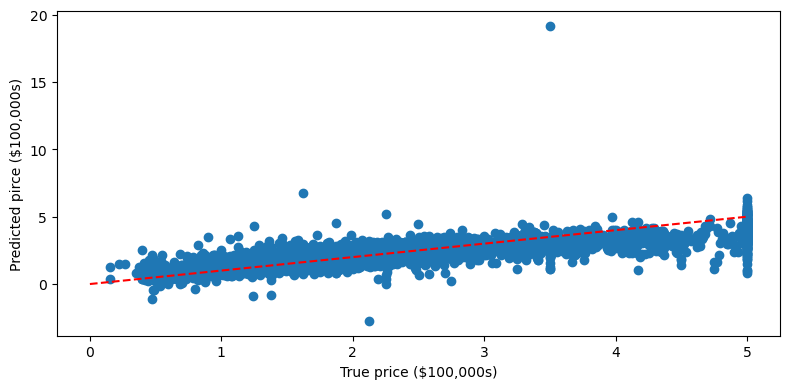

In [415]:
predicted = model_2.predict(x_test)
expected = y_test
plot_california_prices(expected, predicted)

In [ ]:
# from sklearn.datasets import fetch_california_housing
# from sklearn.pipeline import make_pipeline

# california = fetch_california_housing()
# data = california.data
# target = california.target

# model_california = make_pipeline(PolynomialFeatures( degree= 2, include_bias=False), LinearRegression())

# model_california.fit(data, target)


# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2)


# x_test_predict = model_california.predict(x_test)

# plt.figure(figsize=(7,6))
# plt.scatter(X, y)
# plt.plot(x_test, x_test_predict, color='red')
# plt.grid(True)
# plt.show()